# Introduction

The NBA-games dataset is a really great dataset with lots of information about players, teams and results that can be put together in order to create a predictive model for future games. I found this project very interesting as I really like basketball 🏀🏀🏀 and there was room to play around and experiment with the data. The main focus of the notebook is to create a dataset for predictive modelling and at a second step to trim it down to few features in order to enhance interpretability. Let's get started! 🎈🎈🎈

In [7]:
import numpy as np
import pandas as pd
import re
import warnings

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from adjustText import adjust_text
from textwrap import wrap


pd.set_option('display.max_columns', None)

games = pd.read_csv('games.csv')
details = pd.read_csv('games_details.csv')
teams = pd.read_csv('teams.csv')
players = pd.read_csv('C:/Users/cestm/Downloads/stat_kagglenotebook/players (1).csv')
ranking = pd.read_csv('ranking.csv')

details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


# EDA
We have 5 datasets at our disposal:
* Games -> Information about each game and the stats of the teams playing
* Games details -> More detailed information about the individual player stats
* Players -> Information about the name of the player and his team
* Ranking -> Information about the standings of each team on individual days throughout the season
* Teams --> Information about the team including ownership, arena, when it was established etc.

For the EDA we are mainly going to focus on the details dataset in order to have a more granular viewpoint.  Specifically, the focus will be on the yearly stats of the players and how we can use PCA and KMEANS to visualise the differences between individual player performances.

# Preparing the predictive modelling dataset

As always, the crucial task when given NBA stats is to manage to predict the outcome of future games based on the already available stats. But while we could use the datasets as they are, it is much better to try to create new meaningful features to help with prediction accuracy.

The modelling dataset consists of the following components:
* Team ELO rating 
* Team record information (wins, losses, percentages)
* Missing players (due to short term injuries)
* Team player efficiency
* Schedule information (whether the team gave back to back games, how many games in the last 5 days)

In [8]:
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)

# Creating a df with season start and end for excluding preseason and playoff games
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()
t = ranking.loc[(ranking.G == ranking.MAX_S_GAMES)].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()
playoff_dates = t.loc[(t.TEAMS == 30) | 
                      ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | 
                      ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season

# Filtering out details for non-regular season games
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]

# Filtering out games for non-regular season games
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

# Excluding the 2020 season as it was plagued by Covid related results
details = details.loc[details.SEASON != 2020]
games = games.loc[games.SEASON != 2020]
dates = dates.loc[dates.SEASON_ID != 2020]

# Creating a new ranking df with regular season only and values that can be used for modeling 
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric)
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)

# Creating a new games df with regular season only
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

C:\Users\cestm\AppData\Local\Temp\ipykernel_47464\2083988282.py:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)


## Calculating ELO for each team

The [ELO statistic](https://en.wikipedia.org/wiki/Elo_rating_system) was originally divised by Arpad Elo for ranking players in chess games. In order to adjust the calculation for NBA games, the methodology was adjusted by [538](https://fivethirtyeight.com/).  
The main points of the calculation:
* Winning a game increases the ELO of the team and losing a game decreases it
* The amount of increase/decrease depends on a) the margin of victory b) the pre-game expectations for the outcome of the game (which are based on the ELO rating of the two teams)
* Ratings are adjusted after each game

One of the easiest way to assess the ELO figures is to have a look at the end-season results and see which teams finished at the top.

In [9]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)


teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')), 
                         'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []

current_season = 2003
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100
    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values
    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]
    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])
    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    update_elo(team_elo, elo_data.iloc[i])
team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))

## Preparing chart data

team_nick_dict = dict(zip(teams.TEAM_ID, teams.NICKNAME)) 
elo_plot_df = pd.concat(team_elo_l)
elo_plot_df['NICKNAME'] = elo_plot_df.TEAM.map(team_nick_dict)
top_teams = elo_plot_df.groupby('NAME').size().nlargest(4, keep='all').index.tolist()
all_teams = elo_plot_df.NAME.unique()
colors = len(all_teams)
color_dict = {}

#cm = plt.get_cmap('gist_rainbow')
cm = plt.get_cmap('Accent')
color_counter = 0
for i in range(colors):
    if all_teams[i] in top_teams:
        color_dict[all_teams[i]] = np.array(cm(1.*color_counter/len(top_teams)))
        color_counter += 1
    else:
        color_dict[all_teams[i]] = 'white'
        

C:\Users\cestm\AppData\Local\Temp\ipykernel_47464\1596789359.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.6400649998028851' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])
C:\Users\cestm\AppData\Local\Temp\ipykernel_47464\1596789359.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3599350001971149' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
C:\Users\cestm\AppData\Local\Temp\ipykernel_47464\1596789359.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1487.36663242]' has dtype incompatible with int

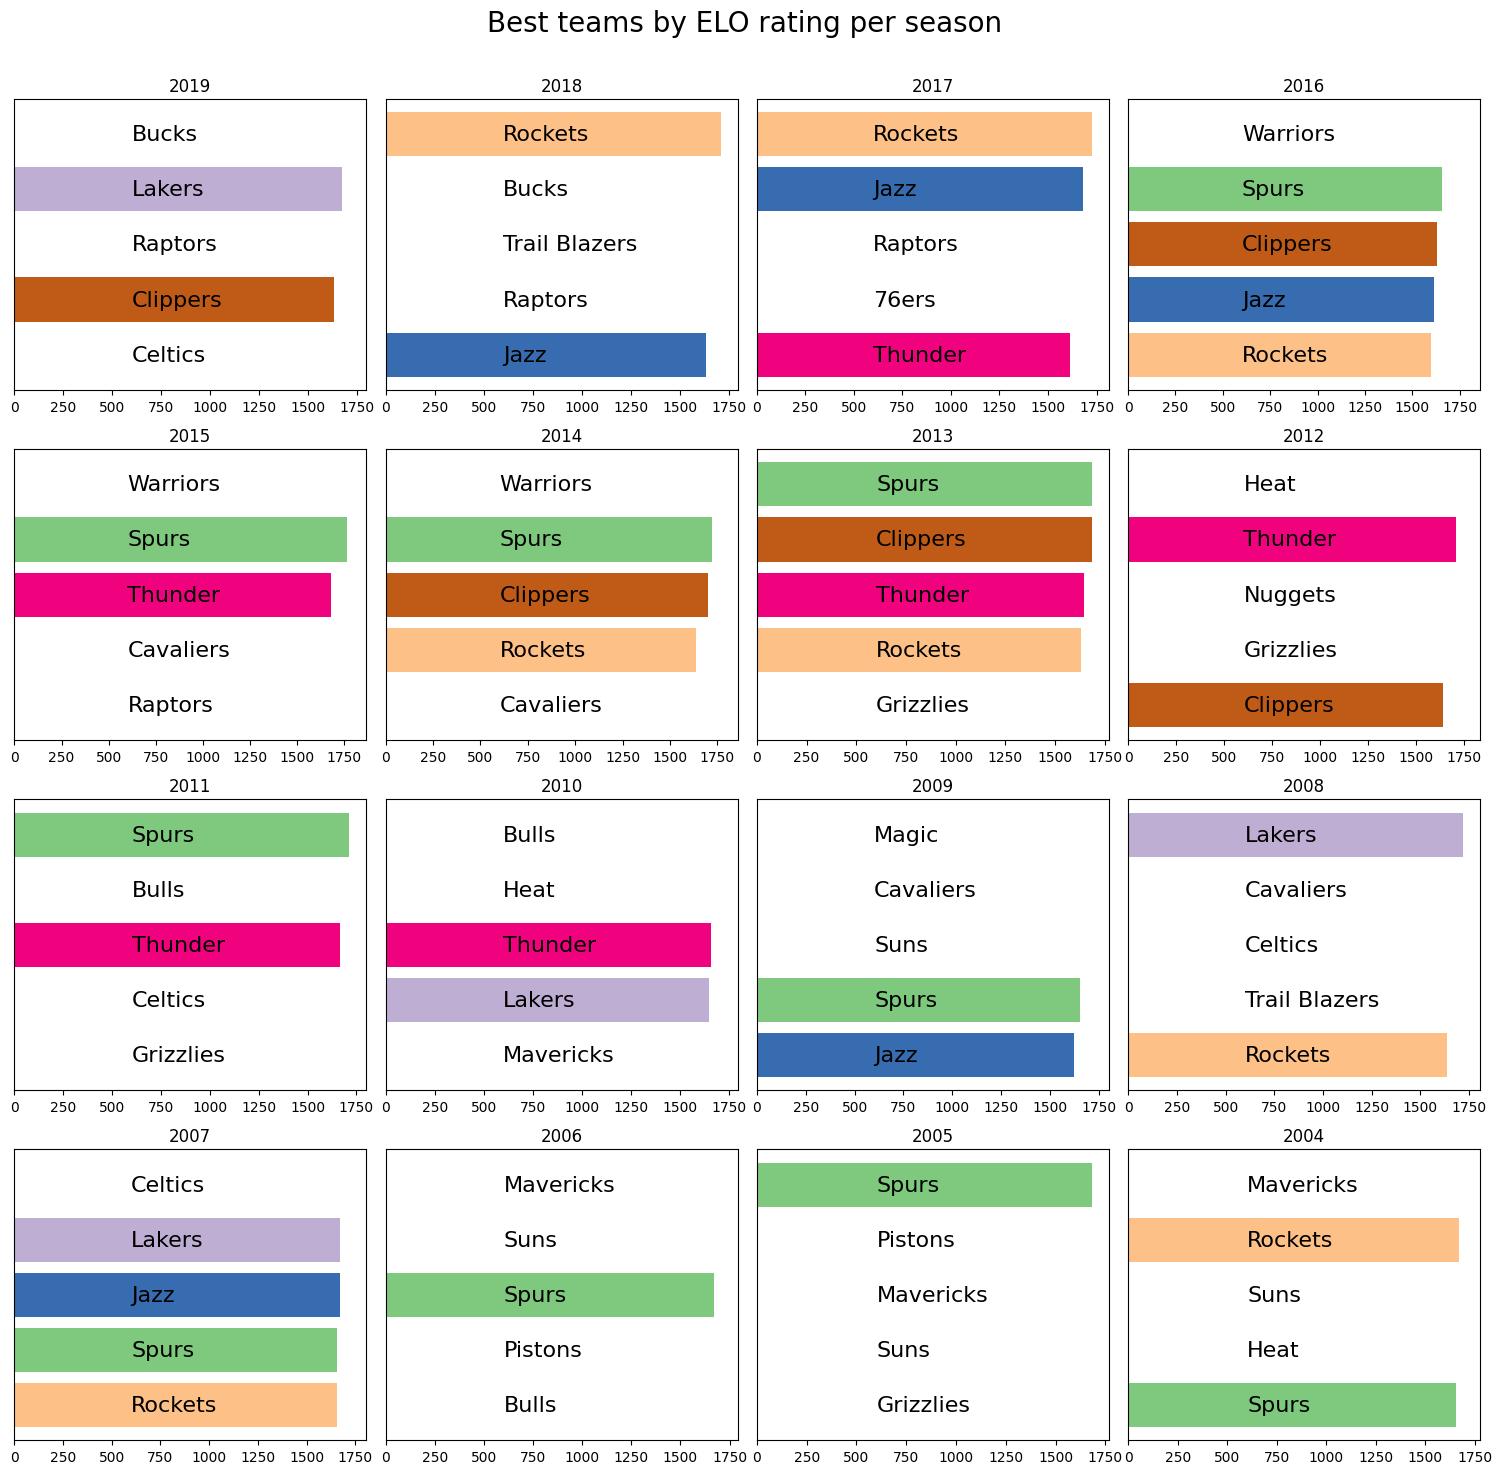

In [10]:
fig,axes = plt.subplots(4, 4, figsize=(15,15))
for i,season in enumerate(range(elo_plot_df.SEASON.max(), elo_plot_df.SEASON.min(), -1)):
    data = elo_plot_df.loc[elo_plot_df.SEASON == season].sort_values(by='ELO')
    axes.ravel()[i].tick_params(left=False, labelleft = False)
    axes.ravel()[i].barh(y=data.NAME, width=data.ELO, color=data.NAME.map(color_dict))
    axes.ravel()[i].set_title(str(season))
    for j,name in enumerate(data.NICKNAME):
        axes.ravel()[i].text(s=name, x=600, y=j, color="black", verticalalignment="center",size=16)
        
fig.suptitle('Best teams by ELO rating per season', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

The ELO rating looks in line with the results of the respective seasons. The most consistent teams in terms of seasons in the top 5 have their own colour. It becomes evident that the Spurs have dominated the last 15 years and are consistently one of the best teams in the league. (Hopefully they will rise again!🤞)  
I found also very interesting that out of the most consistent teams only the Lakers and the Spurs have actually won a championship in those years. Jazz, Rockets, Thunder and Clippers have yet to win the 🏆

Note that the ELO rating was calculated only based on regular season results and not playoff success. This becomes more important in later seasons as teams do load management and have understood that having their players healthy and rested in the playoffs is more important than a couple of ranking spots in the regular season.


In [31]:
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', 
                     left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', 
                     left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO



input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

In [32]:
train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2005)]
valid_data = input_data.loc[input_data.SEASON == 2018]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [34]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
results_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 64.91 %
